In [245]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor

%matplotlib inline

In [246]:
SEED = 123

np.random.default_rng(seed=SEED)

Generator(PCG64) at 0x7FB89937DBA0

In [247]:
[
    pd.__version__,
    np.__version__,
    sklearn.__version__
]

['1.5.3', '1.24.2', '1.2.1']

In [248]:
plt.style.use("fivethirtyeight")

In [249]:
df_raw = pd.read_csv("../data/dados.csv")
df_raw.shape

(999, 199)

In [250]:
df_raw.head()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
0,blues.00000.wav,123.046875,0.350129,0.088772,1.0,0.001883,0.254469,0.112016,0.509971,0.130184,...,-7.189630,1.837867,1.222467,46.941350,32.866340,-23.219631,0.941804,-3.579244,5.497650,blues
1,blues.00001.wav,107.666016,0.340849,0.094976,1.0,0.001808,0.232328,0.089450,0.521089,0.095908,...,-4.961407,4.222943,0.530644,45.788700,27.740532,-17.131062,0.290101,-4.288013,4.693344,blues
2,blues.00002.wav,161.499023,0.363538,0.085257,1.0,0.003168,0.275098,0.130408,0.520045,0.175473,...,-8.082528,0.335357,-2.238128,30.653150,16.524359,-29.785423,-2.112655,-5.789953,1.266118,blues
3,blues.00003.wav,172.265625,0.404854,0.093999,1.0,0.005738,0.320005,0.145432,0.622788,0.141040,...,-4.728713,3.534681,-3.405046,31.965254,16.595015,-21.426252,-3.723261,-6.868982,-0.029808,blues
4,blues.00004.wav,135.999178,0.308526,0.087843,1.0,0.001347,0.201387,0.084953,0.429789,0.091501,...,-9.217802,0.448059,-11.704385,55.190254,4.889852,-41.730530,-10.748793,-15.777891,-6.449556,blues


In [251]:
df_raw.tail()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
994,rock.00095.wav,103.359375,0.351977,0.080479,1.0,0.005424,0.263867,0.130719,0.486072,0.079446,...,-10.667875,-2.157617,-1.198403,49.946903,21.106043,-22.082030,-0.870149,-5.877096,3.354293,rock
995,rock.00096.wav,117.453835,0.398869,0.075117,1.0,0.015388,0.323889,0.184963,0.541574,0.076423,...,-11.642376,-3.169349,-2.791855,31.719294,14.861097,-19.902115,-3.008246,-6.528909,0.997393,rock
996,rock.00097.wav,129.199219,0.431980,0.075221,1.0,0.006835,0.370889,0.216633,0.591718,0.081598,...,-17.128510,-8.109871,-2.104325,29.860994,16.930466,-21.867311,-1.863467,-5.494790,1.414281,rock
997,rock.00098.wav,112.347147,0.362635,0.091532,1.0,0.000592,0.274618,0.110386,0.549156,0.083802,...,-9.732834,-0.612432,-3.587599,41.296356,20.287260,-22.774874,-3.836333,-7.861920,0.380314,rock
998,rock.00099.wav,123.046875,0.358318,0.085817,1.0,0.004010,0.262763,0.128006,0.515196,0.054431,...,-7.819255,3.772562,1.150108,49.735140,29.696540,-21.608265,0.684592,-3.657846,4.877181,rock


In [252]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 199 entries, filename to label
dtypes: float64(197), object(2)
memory usage: 1.5+ MB


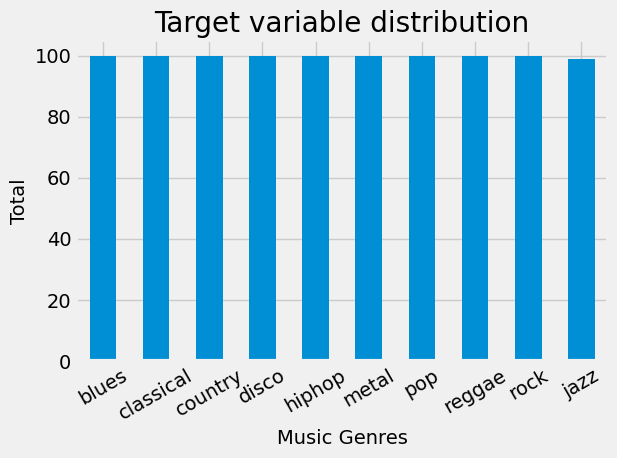

In [253]:
df_raw.select_dtypes("object")["label"].value_counts().plot.bar(rot = 30)
plt.title("Target variable distribution")
plt.xlabel("Music Genres")
plt.ylabel("Total")
plt.tight_layout()

plt.savefig("../images/classes_distribution.png", format = "png")
plt.show()


In [254]:
# só temos um valor unico para toda esta coluna, não nos está a fornecer qualquer tipo de informaçao
df_raw.chroma_stft_max.nunique()

1

In [255]:
# como apareceu só um unico valor para a "chroma_stft_max" vamos verificar para todos os colunas com max no nome
cols_with_max = df_raw.columns[df_raw.columns.str.contains("max")]

In [256]:
# chroma_stft_max é a unica com 1 valor unico por isso é só essa que temos de retirar do dataset 
df_raw[cols_with_max].nunique()

chroma_stft_max                  1
rms_mean_max                   984
spectral_centroid_mean_max     985
spectral_bandwidth_mean_max    985
rolloff_mean_max               436
zero_crossing_rate_mean_max    662
harmony_mean_max               985
perceptr_mean_max              939
mfcc_mean_0_max                985
mfcc_mean_1_max                985
mfcc_mean_2_max                985
mfcc_mean_3_max                985
mfcc_mean_4_max                985
mfcc_mean_5_max                984
mfcc_mean_6_max                984
mfcc_mean_7_max                984
mfcc_mean_8_max                985
mfcc_mean_9_max                984
mfcc_mean_10_max               985
mfcc_mean_11_max               984
mfcc_mean_12_max               984
mfcc_mean_13_max               984
mfcc_mean_14_max               984
mfcc_mean_15_max               984
mfcc_mean_16_max               984
mfcc_mean_17_max               984
mfcc_mean_18_max               984
mfcc_mean_19_max               985
dtype: int64

In [257]:
def convert_numeric(df):
    df = df.copy()
    df[df.select_dtypes("number").columns] = df.select_dtypes("number").astype(np.float32)
    return df
    
def convert_category(df):
    df = df.copy()
    df["label"] = df["label"].astype("category")
    return df


In [258]:
df = (
    df_raw
    .pipe(convert_numeric)
    .pipe(convert_category)
    .drop(["filename","chroma_stft_max"], axis = 1)
    .rename(columns = {"label":"genre"})
    .sample(frac = 1, random_state = SEED)
    .reset_index(drop = True)
)

In [259]:
df.head()

,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,rms_mean_var,rms_mean_max,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,genre
0,112.347145,0.303251,0.089593,0.001021,0.192122,0.072654,0.431641,0.026787,0.000342,0.109245,...,-7.092338,4.157803,-3.818604,88.638634,37.769127,-29.682255,-5.023259,-9.993509,1.511925,classical
1,161.499023,0.376988,0.083790,0.003654,0.283156,0.150821,0.535613,0.204271,0.001920,0.354226,...,-5.752795,2.507965,-3.078908,51.755867,16.769207,-24.104900,-3.161209,-7.775723,1.794894,country
2,135.999176,0.401009,0.089657,0.002326,0.331715,0.145864,0.598354,0.182285,0.003976,0.359245,...,-7.306152,1.171250,0.705028,55.644600,23.745577,-22.897854,0.639649,-4.493629,5.592843,blues
3,161.499023,0.325428,0.087600,0.001496,0.224143,0.095076,0.459756,0.071379,0.000794,0.171586,...,-5.306351,4.497449,6.321081,100.530167,35.653419,-19.270657,6.225543,-0.877847,12.986521,jazz
4,112.347145,0.294611,0.088108,0.002020,0.185114,0.071379,0.403091,0.044323,0.001092,0.179927,...,-9.735260,3.697661,-3.284700,97.682816,31.533157,-24.643005,-4.996558,-10.412316,1.571471,classical


In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 197 entries, tempo to genre
dtypes: category(1), float32(196)
memory usage: 766.3 KB


In [261]:
df.isna().sum().sum()

0

In [262]:
pd.DataFrame(df.isnull().sum(), columns=["Number of missing values"])

,Number of missing values
tempo,0
chroma_stft_mean,0
chroma_stft_var,0
chroma_stft_min,0
chroma_stft_median,0
...,...
mfcc_mean_19_min,0
mfcc_mean_19_median,0
mfcc_mean_19_qt1,0
mfcc_mean_19_qt2,0


In [263]:
# df.plot(
#     kind = "hist",
#     subplots = True,
#     layout = (-1,4),
#     figsize = (20, 300), 
#     legend = False,
#     sharey = True)

# plt.show()

In [264]:
le = LabelEncoder()
df["genre"] = le.fit_transform(df["genre"])

In [265]:
# le.inverse_transform(df.iloc[np.random.randint(0,999, 10), -1])

In [266]:
# sns.pairplot(df, diag_kind="kde", vars = df.columns[:7])
# plt.show()

In [267]:
y = df.pop("genre").values
col_names = df.columns.to_list()
X = df.values

In [268]:
lof = LocalOutlierFactor()
yhet = lof.fit_predict(X)
mask = yhet != -1

In [269]:
X,y = X[mask,:], y[mask] 

In [270]:
scaler = StandardScaler()
X = scaler.fit_transform(X, y)
X = pd.DataFrame(X, columns=col_names)

In [271]:
corr_table = X.corr().abs()
upper = corr_table.where(np.triu(np.ones(corr_table.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

In [272]:
len(to_drop)

91

In [273]:
# sns.pairplot(corr_table, diag_kind="kde", vars = to_drop[:7])
# plt.show()

In [274]:
X = X.drop(to_drop, axis=1)
X.shape

(973, 105)

In [275]:
col_names = X.columns

In [276]:
vt = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = vt.fit_transform(X,y)

In [277]:
X = pd.DataFrame(X, columns=col_names)

In [278]:
# X.plot(
#     kind = "hist",
#     bins = 100,
#     subplots = True,
#     layout = (-1,4),
#     figsize = (10, 50), 
#     legend = False,
#     sharey = True,
#     # title=X.columns.to_list()
# )
# plt.tight_layout()
# plt.show()

In [279]:
selector = SelectKBest(score_func=f_classif, k = 20)
X = selector.fit_transform(X, y)

In [280]:
score_dict = {name:score for name, score in zip(selector.get_feature_names_out(), selector.scores_)}
score_dicted = {k: v for k, v in sorted(score_dict.items(), key=lambda x : x[1], reverse = True)}
score_dicted

{'chroma_stft_var': 179.24323,
 'perceptr_mean_mean': 152.7314,
 'mfcc_mean_0_max': 133.34816,
 'spectral_bandwidth_mean_max': 96.52079,
 'spectral_centroid_mean_var': 89.80075,
 'zero_crossing_rate_mean_var': 87.29734,
 'rms_mean_mean': 82.72548,
 'rms_mean_max': 72.67649,
 'chroma_stft_min': 69.742424,
 'mfcc_mean_3_mean': 66.48408,
 'spectral_centroid_mean_mean': 66.47875,
 'mfcc_mean_3_max': 58.869778,
 'mfcc_mean_2_max': 55.134045,
 'perceptr_mean_var': 44.07135,
 'spectral_centroid_mean_max': 38.843983,
 'mfcc_mean_0_mean': 32.75758,
 'mfcc_mean_1_min': 30.81064,
 'mfcc_mean_5_max': 29.933998,
 'chroma_stft_mean': 9.714024,
 'mfcc_mean_3_min': 2.6439092}

In [282]:
arg_sorted = np.argsort(selector.scores_)

array(['chroma_stft_mean', 'chroma_stft_var', 'chroma_stft_min',
       'rms_mean_mean', 'rms_mean_max', 'spectral_centroid_mean_mean',
       'spectral_centroid_mean_var', 'spectral_centroid_mean_max',
       'spectral_bandwidth_mean_max', 'zero_crossing_rate_mean_var',
       'perceptr_mean_mean', 'perceptr_mean_var', 'mfcc_mean_0_mean',
       'mfcc_mean_0_max', 'mfcc_mean_1_min', 'mfcc_mean_2_max',
       'mfcc_mean_3_mean', 'mfcc_mean_3_max', 'mfcc_mean_3_min',
       'mfcc_mean_5_max'], dtype=object)

ValueError: The number of FixedLocator locations (105), usually from a call to set_ticks, does not match the number of labels (20).

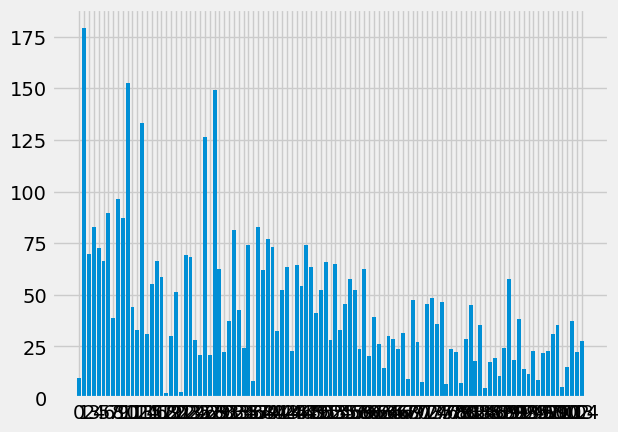

In [283]:
# plt.bar([*range(len(selector.scores_))], selector.scores_)
# plt.xticks([*range(len(selector.scores_))], selector.get_feature_names_out())